# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
!ls

AZDIAS_Feature_Summary.csv	  terms_and_conditions
Data_Dictionary.md		  Udacity_AZDIAS_Subset.csv
Identify_Customer_Segments.ipynb  Udacity_CUSTOMERS_Subset.csv


In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [9]:
#Naturally missing data
naturally_missing = azdias.isnull().sum().reset_index()
naturally_missing.columns = ['attribute', 'naturally_missing']
naturally_missing

,attribute,naturally_missing
0,AGER_TYP,0
1,ALTERSKATEGORIE_GROB,0
2,ANREDE_KZ,0
3,CJT_GESAMTTYP,4854
4,FINANZ_MINIMALIST,0
5,FINANZ_SPARER,0
6,FINANZ_VORSORGER,0
7,FINANZ_ANLEGER,0
8,FINANZ_UNAUFFAELLIGER,0
9,FINANZ_HAUSBAUER,0


Curiously, while most of the values in the list under the column 'missing_or_unknown' are integers, some of them have strings such as 'X' and 'XX' (e.g. CAMEO_DEU_2015). Therefore, some deep-dive in needed.

In [10]:
for col in azdias.columns:
    print('{:<21} --- {}'.format(col, azdias[col].dtype))

AGER_TYP              --- int64
ALTERSKATEGORIE_GROB  --- int64
ANREDE_KZ             --- int64
CJT_GESAMTTYP         --- float64
FINANZ_MINIMALIST     --- int64
FINANZ_SPARER         --- int64
FINANZ_VORSORGER      --- int64
FINANZ_ANLEGER        --- int64
FINANZ_UNAUFFAELLIGER --- int64
FINANZ_HAUSBAUER      --- int64
FINANZTYP             --- int64
GEBURTSJAHR           --- int64
GFK_URLAUBERTYP       --- float64
GREEN_AVANTGARDE      --- int64
HEALTH_TYP            --- int64
LP_LEBENSPHASE_FEIN   --- float64
LP_LEBENSPHASE_GROB   --- float64
LP_FAMILIE_FEIN       --- float64
LP_FAMILIE_GROB       --- float64
LP_STATUS_FEIN        --- float64
LP_STATUS_GROB        --- float64
NATIONALITAET_KZ      --- int64
PRAEGENDE_JUGENDJAHRE --- int64
RETOURTYP_BK_S        --- float64
SEMIO_SOZ             --- int64
SEMIO_FAM             --- int64
SEMIO_REL             --- int64
SEMIO_MAT             --- int64
SEMIO_VERT            --- int64
SEMIO_LUST            --- int64
SEMIO_ERL             

In [11]:
(azdias.dtypes == np.int64).sum()

32

In [12]:
(azdias.dtypes == np.float64).sum()

49

In [13]:
(azdias.dtypes == np.object).sum()

4

In [14]:
azdias.dtypes[azdias.dtypes == np.object]

OST_WEST_KZ        object
CAMEO_DEUG_2015    object
CAMEO_DEU_2015     object
CAMEO_INTL_2015    object
dtype: object

The function below creates a mapping for converting the `missing_or_unknown` string representation into the appropriate list format.

In [15]:
def create_mapping_for_imputation():
    replace_dic = {}
    for i, val in feat_info.iterrows():
        dtype_ = azdias[val.attribute].dtype
        li = []
        for v in val.missing_or_unknown.split(','):
            try:
                if dtype_==np.int64:
                    li.append(np.int64(v.strip('[]')))
                elif dtype_==np.float64:
                    li.append(np.float64(v.strip('[]')))
                else:
                    li.append(v.strip('[]'))
            except:
                pass             
        replace_dic[val.attribute] = li 
    return replace_dic

In [16]:
mapping_dic = create_mapping_for_imputation()

In [17]:
mapping_dic

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ALTER_HH': [0.0],
 'ANREDE_KZ': [-1, 0],
 'ANZ_HAUSHALTE_AKTIV': [0.0],
 'ANZ_HH_TITEL': [],
 'ANZ_PERSONEN': [],
 'ANZ_TITEL': [],
 'ARBEIT': [-1.0, 9.0],
 'BALLRAUM': [-1.0],
 'CAMEO_DEUG_2015': ['-1', 'X'],
 'CAMEO_DEU_2015': ['XX'],
 'CAMEO_INTL_2015': ['-1', 'XX'],
 'CJT_GESAMTTYP': [0.0],
 'EWDICHTE': [-1.0],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1.0, 0.0],
 'GEBAEUDETYP_RASTER': [],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [],
 'GREEN_AVANTGARDE': [],
 'HEALTH_TYP': [-1, 0],
 'HH_EINKOMMEN_SCORE': [-1.0, 0.0],
 'INNENSTADT': [-1.0],
 'KBA05_ANTG1': [-1.0],
 'KBA05_ANTG2': [-1.0],
 'KBA05_ANTG3': [-1.0],
 'KBA05_ANTG4': [-1.0],
 'KBA05_BAUMAX': [-1.0, 0.0],
 'KBA05_GBZ': [-1.0, 0.0],
 'KBA13_ANZAHL_PKW': [],
 'KKK': [-1.0, 0.0],
 'KK_KUNDENTYP': [-1.0],
 'KONS

In [18]:
cols_ = []
missing_or_unknown_ = []
for col in azdias.columns:
    cols_.append(col)
    missing_or_unknown_.append(azdias[col].isin(mapping_dic[col]).sum())
missing_or_unknown = pd.DataFrame({'attribute':cols_, 'missing_or_unknown':missing_or_unknown_})

`all missing` dataframe summarizes how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing.

In [19]:
all_missing = pd.merge(naturally_missing, missing_or_unknown, on='attribute', how='inner')
all_missing['all_missing_or_unknown'] = all_missing.naturally_missing + all_missing.missing_or_unknown
all_missing

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown
0,AGER_TYP,0,685843,685843
1,ALTERSKATEGORIE_GROB,0,2881,2881
2,ANREDE_KZ,0,0,0
3,CJT_GESAMTTYP,4854,0,4854
4,FINANZ_MINIMALIST,0,0,0
5,FINANZ_SPARER,0,0,0
6,FINANZ_VORSORGER,0,0,0
7,FINANZ_ANLEGER,0,0,0
8,FINANZ_UNAUFFAELLIGER,0,0,0
9,FINANZ_HAUSBAUER,0,0,0


Time to replace all `missing_or_unknown` values to NaNs.

In [20]:
for k, v in mapping_dic.items():
    azdias[k].replace({r: np.nan for r in v}, inplace=True)

Just to double check we've replaced the `missing_or_unknown` values to NaNs correctly, let's compare the actual and expected number of NaNs for each attribute.

In [21]:
azdias.isnull().sum().values.shape

(85,)

In [22]:
check = azdias.isnull().sum().reset_index()
check.columns = ['attribute', 'final_nan']
pd.merge(all_missing, check, on='attribute')

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,final_nan
0,AGER_TYP,0,685843,685843,685843
1,ALTERSKATEGORIE_GROB,0,2881,2881,2881
2,ANREDE_KZ,0,0,0,0
3,CJT_GESAMTTYP,4854,0,4854,4854
4,FINANZ_MINIMALIST,0,0,0,0
5,FINANZ_SPARER,0,0,0,0
6,FINANZ_VORSORGER,0,0,0,0
7,FINANZ_ANLEGER,0,0,0,0
8,FINANZ_UNAUFFAELLIGER,0,0,0,0
9,FINANZ_HAUSBAUER,0,0,0,0


Indeed, the expected and actual number of NaNs for each attribute match with each other.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

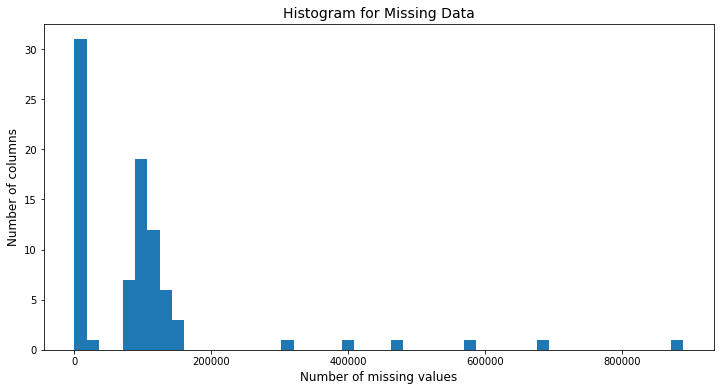

In [23]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(azdias.isnull().sum().values, bins=50)
ax.set_xlabel('Number of missing values', fontsize=12)
ax.set_ylabel('Number of columns', fontsize=12)
ax.set_title('Histogram for Missing Data', fontsize=14)
plt.show()


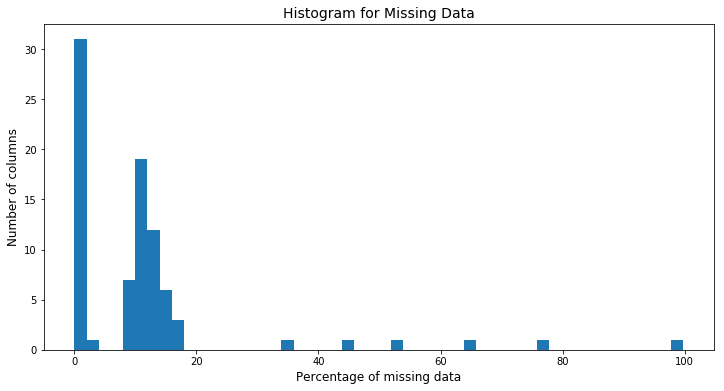

In [24]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(azdias.isnull().sum().values*100/azdias.shape[0], bins=50)
ax.set_xlabel('Percentage of missing data', fontsize=12)
ax.set_ylabel('Number of columns', fontsize=12)
ax.set_title('Histogram for Missing Data', fontsize=14)
plt.show()

In [25]:
all_missing['pct_of_missing'] = all_missing['all_missing_or_unknown']*100/azdias.shape[0]
all_missing.sort_values('pct_of_missing', ascending=False).head(10)

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
40,TITEL_KZ,73499,815562,889061,99.757636
0,AGER_TYP,0,685843,685843,76.955435
47,KK_KUNDENTYP,584612,0,584612,65.596749
64,KBA05_BAUMAX,133324,343200,476524,53.468668
11,GEBURTSJAHR,0,392318,392318,44.020282
43,ALTER_HH,73499,236768,310267,34.813699
70,KKK,121196,36868,158064,17.735668
73,REGIOTYP,121196,36868,158064,17.735668
48,W_KEIT_KIND_HH,107602,40386,147988,16.605084
60,KBA05_ANTG1,133324,0,133324,14.959701


As is apparent, while most of the columns have less than 20% of missing data, 6 columns (displayed above) have more than 30% missing data (clearly, these are the otlier columns).

In [26]:
# Investigate patterns in the amount of missing data in each column.
all_missing.all_missing_or_unknown.value_counts()

0         24
116515     7
4854       6
133324     6
93148      4
73499      4
111196     3
99352      3
93740      3
97375      2
77792      2
158064     2
93155      1
584612     1
108164     1
685843     1
147988     1
99611      1
97274      1
108315     1
73969      1
18348      1
97632      1
476524     1
2881       1
105800     1
97008      1
310267     1
94572      1
889061     1
392318     1
Name: all_missing_or_unknown, dtype: int64

In [27]:
all_missing[all_missing.all_missing_or_unknown==116515]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
75,PLZ8_ANTG1,116515,0,116515,13.073637
76,PLZ8_ANTG2,116515,0,116515,13.073637
77,PLZ8_ANTG3,116515,0,116515,13.073637
78,PLZ8_ANTG4,116515,0,116515,13.073637
79,PLZ8_BAUMAX,116515,0,116515,13.073637
80,PLZ8_HHZ,116515,0,116515,13.073637
81,PLZ8_GBZ,116515,0,116515,13.073637


In [28]:
all_missing[all_missing.all_missing_or_unknown==4854]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
3,CJT_GESAMTTYP,4854,0,4854,0.544646
12,GFK_URLAUBERTYP,4854,0,4854,0.544646
19,LP_STATUS_FEIN,4854,0,4854,0.544646
20,LP_STATUS_GROB,4854,0,4854,0.544646
23,RETOURTYP_BK_S,4854,0,4854,0.544646
72,ONLINE_AFFINITAET,4854,0,4854,0.544646


In [29]:
all_missing[all_missing.all_missing_or_unknown==133324]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
60,KBA05_ANTG1,133324,0,133324,14.959701
61,KBA05_ANTG2,133324,0,133324,14.959701
62,KBA05_ANTG3,133324,0,133324,14.959701
63,KBA05_ANTG4,133324,0,133324,14.959701
65,KBA05_GBZ,133324,0,133324,14.959701
71,MOBI_REGIO,133324,0,133324,14.959701


In [30]:
all_missing[all_missing.all_missing_or_unknown==93148]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
52,GEBAEUDETYP,93148,0,93148,10.451729
54,MIN_GEBAEUDEJAHR,93148,0,93148,10.451729
55,OST_WEST_KZ,93148,0,93148,10.451729
56,WOHNLAGE,93148,0,93148,10.451729


In [31]:
all_missing[all_missing.all_missing_or_unknown==73499]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
39,SOHO_KZ,73499,0,73499,8.247
44,ANZ_PERSONEN,73499,0,73499,8.247
45,ANZ_TITEL,73499,0,73499,8.247
49,WOHNDAUER_2008,73499,0,73499,8.247


In [32]:
all_missing[all_missing.all_missing_or_unknown==111196]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
14,HEALTH_TYP,0,111196,111196,12.476816
38,SHOPPER_TYP,0,111196,111196,12.476816
41,VERS_TYP,0,111196,111196,12.476816


In [33]:
all_missing[all_missing.all_missing_or_unknown==99352]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
57,CAMEO_DEUG_2015,98979,373,99352,11.147852
58,CAMEO_DEU_2015,98979,373,99352,11.147852
59,CAMEO_INTL_2015,98979,373,99352,11.147852


In [34]:
all_missing[all_missing.all_missing_or_unknown==93740]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
66,BALLRAUM,93740,0,93740,10.518154
67,EWDICHTE,93740,0,93740,10.518154
68,INNENSTADT,93740,0,93740,10.518154


In [35]:
all_missing[all_missing.all_missing_or_unknown==97375]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
82,ARBEIT,97216,159,97375,10.926022
84,RELAT_AB,97216,159,97375,10.926022


In [36]:
all_missing[all_missing.all_missing_or_unknown==77792]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
17,LP_FAMILIE_FEIN,4854,72938,77792,8.728699
18,LP_FAMILIE_GROB,4854,72938,77792,8.728699


In [37]:
all_missing[all_missing.all_missing_or_unknown==158064]

,attribute,naturally_missing,missing_or_unknown,all_missing_or_unknown,pct_of_missing
70,KKK,121196,36868,158064,17.735668
73,REGIOTYP,121196,36868,158064,17.735668


**Observations**

In [38]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

print('Original shape: ', azdias.shape)
azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'],
           axis=1, inplace=True)
print('Shape after removing the outlier columns', azdias.shape)

Original shape:  (891221, 85)
Shape after removing the outlier columns (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- While most of the columns have less than 20% of missing data, 6 columns `'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'` have more than 30% missing data (clearly, these are the otlier columns, and hence removed).
- 24 columns have no missing data at all (good). 
- 7 columns have 13% missing data. Interestingly, all 7 of them start with `PLZ8`. Hence, these are related columns.
- 6 columns have ~0.5% missing data. No common pattern in the column names found.
- Another 6 columns have ~15% of missing data. 5 of the 6 columns have names starting with `KBA05`. 
- 4 columns have ~10% of missing data. No common pattern in the column names found.
- Another 4 columns have ~8% missing data. 2 of the 4 columns have names starting with `ANZ`
- 3 columns have ~12% missing data. All of them have `TYP` as suffixes in their column names.
- Another 3 columns have ~11% missing data. All of them have `CAMEO` as prefixes in their column names.
- Another 3 columns have ~10.5% missing data. No pattern in the column names found.
- 2 columns have ~11% missing data. No pattern in the column names found.
- Another 2 columns have ~8.7% missing data. All of them have `LP_FMILIE` as prefixes in their column names.
- Another 2 columns have ~17.7% missing data. No pattern in the column names found.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

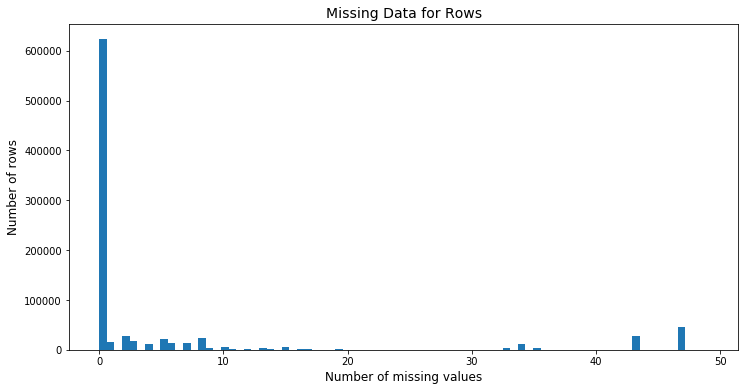

In [39]:
# How much data is missing in each row of the dataset?

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(azdias.isnull().sum(axis=1).values, bins=80)
ax.set_xlabel('Number of missing values', fontsize=12)
ax.set_ylabel('Number of rows', fontsize=12)
ax.set_title('Missing Data for Rows', fontsize=14)
plt.show()

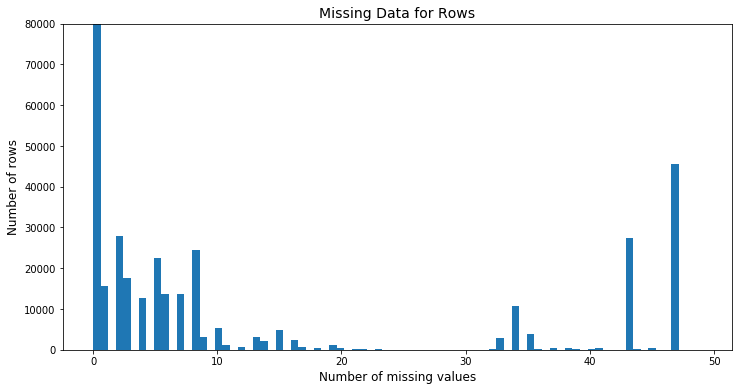

In [40]:
#Let's zoom in 

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(azdias.isnull().sum(axis=1).values, bins=80)
ax.set_xlabel('Number of missing values', fontsize=12)
ax.set_ylabel('Number of rows', fontsize=12)
ax.set_title('Missing Data for Rows', fontsize=14)
ax.set_ylim((0, 80000))
plt.show()

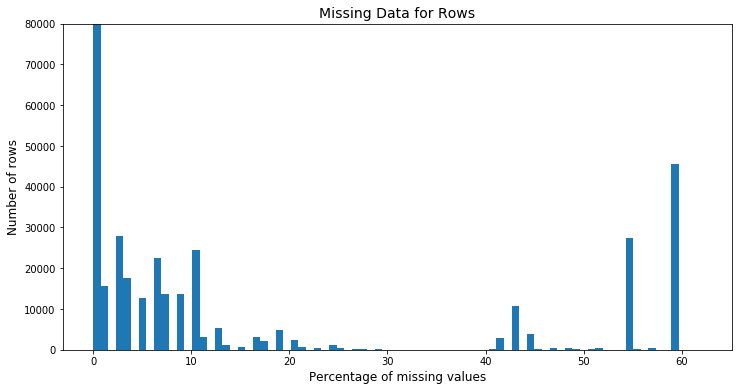

In [41]:
#Let's zoom in 

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(azdias.isnull().sum(axis=1).values*100/azdias.shape[1], bins=80)
ax.set_xlabel('Percentage of missing values', fontsize=12)
ax.set_ylabel('Number of rows', fontsize=12)
ax.set_title('Missing Data for Rows', fontsize=14)
ax.set_ylim((0, 80000))
plt.show()

In [42]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
pct_threshold = 0.4
threshold = int(pct_threshold*azdias.shape[1])
print('Threshold:', threshold)

indexes_ = azdias.isnull().sum(axis=1)
below_thres = azdias[indexes_<threshold]
above_thres = azdias[indexes_>=threshold]

Threshold: 31


In [43]:
below_thres.shape

(798067, 79)

In [44]:
above_thres.shape

(93154, 79)

In [45]:
below_thres.shape[0] + above_thres.shape[0] == azdias.shape[0]

True

In [46]:
def plot_differences(col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].bar(below_thres[col].value_counts().index, 
             below_thres[col].value_counts().values*100/below_thres.shape[0])
    ax[0].set_ylabel('Percentage of rows (normalized frequencies)', fontsize=12)
    ax[0].set_xlabel('Codes', fontsize=12)
    ax[0].set_title('Below Threshold Subset', fontsize=14)
    ax[1].bar(above_thres[col].value_counts().index,
             above_thres[col].value_counts().values*100/above_thres.shape[0])
    ax[1].set_ylabel('Percentage of rows (normalized frequencies)', fontsize=12)
    ax[1].set_xlabel('Codes', fontsize=12)
    ax[1].set_title('Above Threshold Subset', fontsize=14)
    fig.suptitle('Comparision for '+col, fontsize=16)
    plt.show()

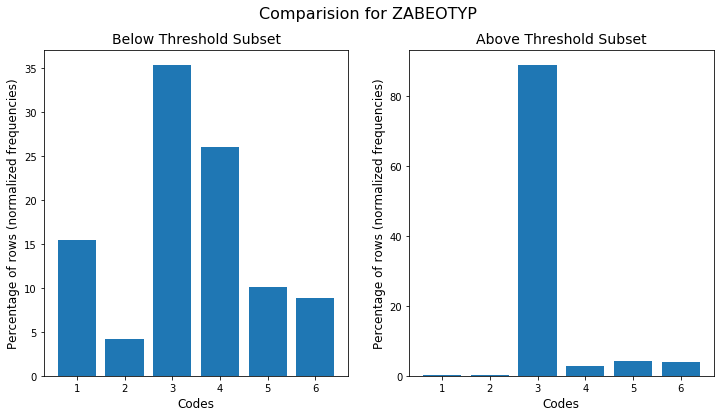

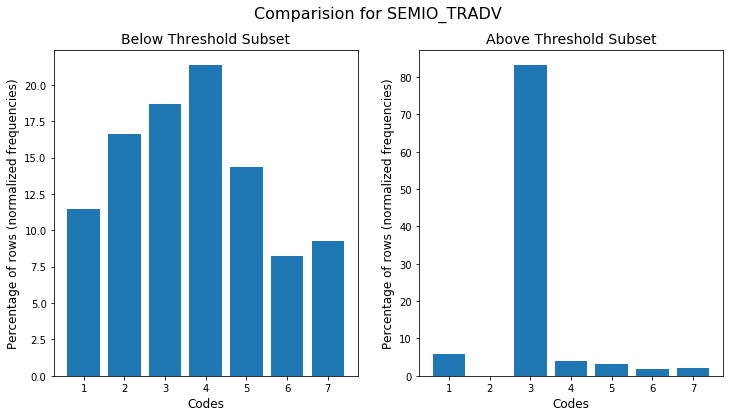

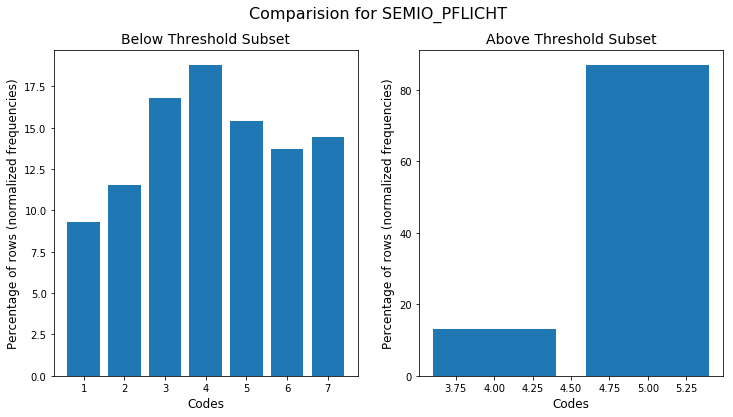

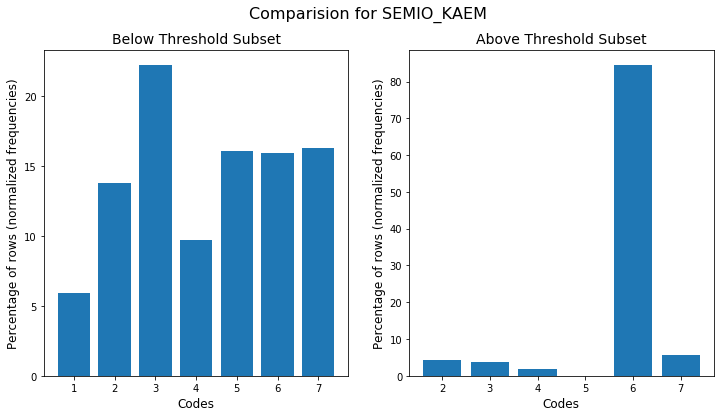

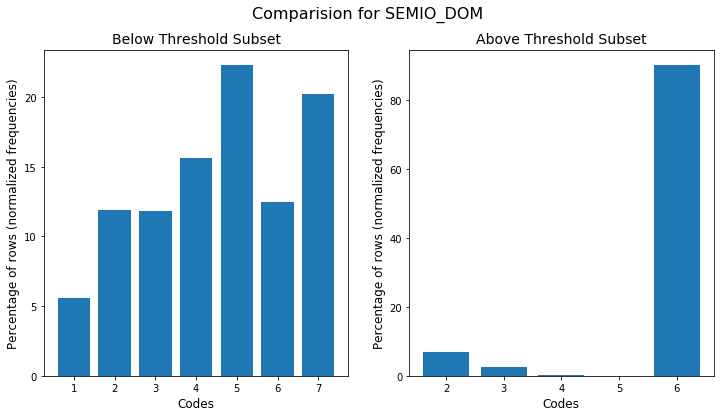

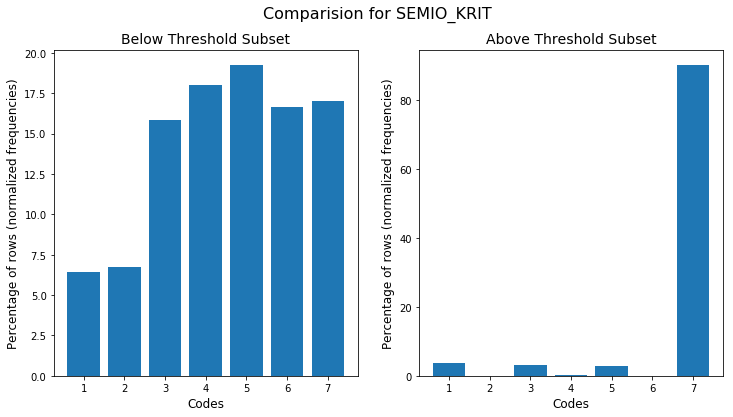

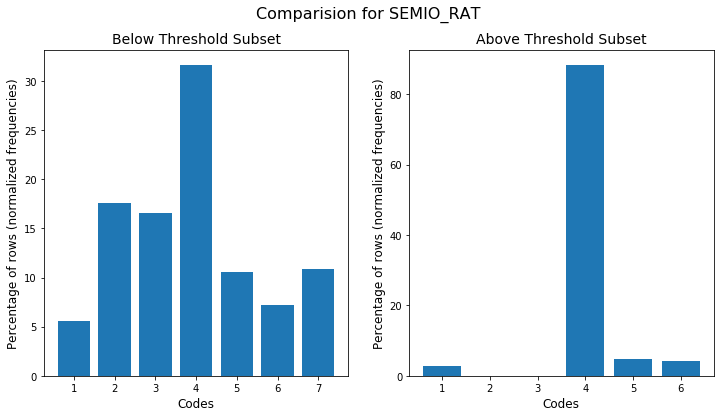

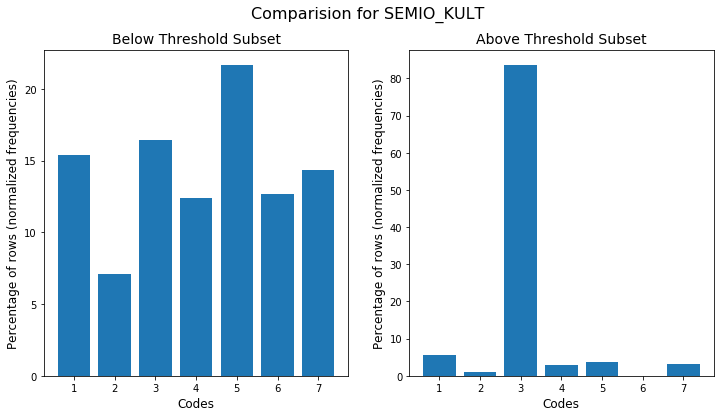

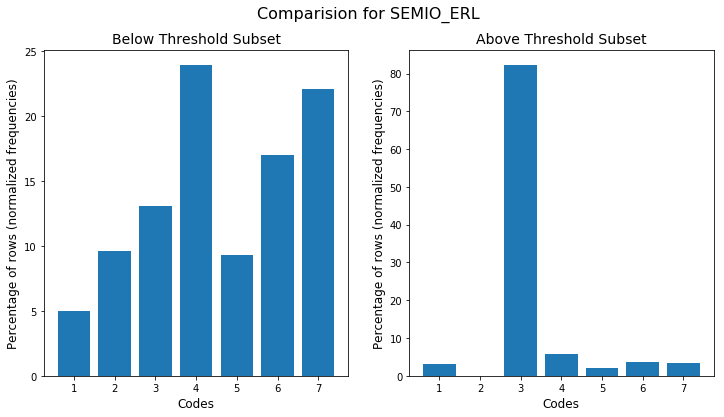

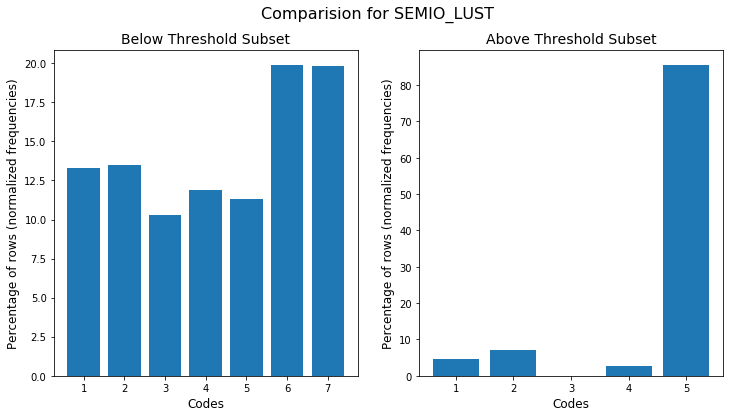

In [47]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for c in all_missing.sort_values('pct_of_missing').iloc[:10].attribute.values:
    plot_differences(c)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Yes, the data with losts of missing values (above 31 columns) are qualitatively different from the data with few or no missing values. This is clearly visible from the barplots above. As is apparent, the distribution of codes for subsets of data above and below the thresholds are starkly different. Moreover, this difference is not specific to some columns as all the (sample) 10 columns (for which the percentage of missing data is 0) display the similar trend.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [48]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


Let's only consider columns that were not removed already.

In [49]:
feat_info_ = pd.merge(pd.DataFrame({'col':azdias.columns}), feat_info, left_on='col', right_on='attribute', how='inner')

In [50]:
#All the features
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [51]:
# How many features are there of each data type?
#Features that were not already removed
feat_info_.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [52]:
feat_info_[feat_info_.type=='mixed']

,col,attribute,information_level,type,missing_or_unknown
13,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_FEIN,person,mixed,[0]
14,LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_GROB,person,mixed,[0]
20,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
51,WOHNLAGE,WOHNLAGE,building,mixed,[-1]
54,CAMEO_INTL_2015,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
73,PLZ8_BAUMAX,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [53]:
feat_info_[feat_info_.type=='categorical']

,col,attribute,information_level,type,missing_or_unknown
1,ANREDE_KZ,ANREDE_KZ,person,categorical,"[-1,0]"
2,CJT_GESAMTTYP,CJT_GESAMTTYP,person,categorical,[0]
9,FINANZTYP,FINANZTYP,person,categorical,[-1]
10,GFK_URLAUBERTYP,GFK_URLAUBERTYP,person,categorical,[]
11,GREEN_AVANTGARDE,GREEN_AVANTGARDE,person,categorical,[]
15,LP_FAMILIE_FEIN,LP_FAMILIE_FEIN,person,categorical,[0]
16,LP_FAMILIE_GROB,LP_FAMILIE_GROB,person,categorical,[0]
17,LP_STATUS_FEIN,LP_STATUS_FEIN,person,categorical,[0]
18,LP_STATUS_GROB,LP_STATUS_GROB,person,categorical,[0]
19,NATIONALITAET_KZ,NATIONALITAET_KZ,person,categorical,"[-1,0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [54]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

codes_per_feature = {}
for a in feat_info_[(feat_info_.type=='categorical')].attribute:
    print('\n')
    print('-'*30)
    n_codes = azdias[a].value_counts().shape[0]
    print('{} has {} unique values'.format(a, n_codes))
    print('-'*30)
    print(azdias[a].value_counts())
    print('-'*30)
    if n_codes in codes_per_feature.keys():
        codes_per_feature[n_codes].append(a)
    else:
        codes_per_feature[n_codes] = [a]



------------------------------
ANREDE_KZ has 2 unique values
------------------------------
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
------------------------------


------------------------------
CJT_GESAMTTYP has 6 unique values
------------------------------
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
------------------------------


------------------------------
FINANZTYP has 6 unique values
------------------------------
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
------------------------------


------------------------------
GFK_URLAUBERTYP has 12 unique values
------------------------------
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
------------------------------

In [55]:
codes_per_feature

{2: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'],
 3: ['NATIONALITAET_KZ'],
 4: ['SHOPPER_TYP'],
 5: ['LP_FAMILIE_GROB', 'LP_STATUS_GROB'],
 6: ['CJT_GESAMTTYP', 'FINANZTYP', 'ZABEOTYP'],
 7: ['GEBAEUDETYP'],
 9: ['CAMEO_DEUG_2015'],
 10: ['LP_STATUS_FEIN'],
 11: ['LP_FAMILIE_FEIN'],
 12: ['GFK_URLAUBERTYP'],
 44: ['CAMEO_DEU_2015']}

As is apparent from the above output, `ANREDE_KZ`,  `GREEN_AVANTGARDE`, `SOHO_KZ`, `VERS_TYP` and `OST_WEST_KZ` are the only binary features.

In [56]:
azdias['ANREDE_KZ'].value_counts()

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

In [57]:
azdias['GREEN_AVANTGARDE'].value_counts()

0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64

In [58]:
azdias['SOHO_KZ'].value_counts()

0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64

In [59]:
azdias['VERS_TYP'].value_counts()

2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64

In [60]:
azdias['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

Converting `OST_WEST_KZ` as a dummy variable (since it is the only binary feature with non-numeric values)

In [61]:
dummy = pd.get_dummies(azdias['OST_WEST_KZ'], prefix='OST_WEST_KZ')

In [62]:
dummy.head()

,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1


In [63]:
azdias['OST_WEST_KZ_O'] = dummy['OST_WEST_KZ_O']
azdias['OST_WEST_KZ_W'] = dummy['OST_WEST_KZ_W']

#Dropping the original column
azdias.drop('OST_WEST_KZ', axis=1, inplace=True)

In [64]:
# Re-encode categorical variable(s) to be kept in the analysis.
#the only categorical variable with too many levels and unintuitive ordering
azdias.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [65]:
for k, v in codes_per_feature.items():
    for col in v:
        if col in azdias.columns:
            azdias[col] = azdias[col].astype(np.float32)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

GEBAEUDETYP
As discussed above, only `CAMEO_DEU_2015` feature has been dropped. This is because this column has too many levels to it, and hence dummitizing it will create too many additional columns. Also, unlike other features, there is no intutive ordering within its levels. Hence, I've decided to drop it. 

The binary feature `OST_WEST_KZ` has been dropped after being dummitized. 

All other categorical features were not dropped owing to the fact that although these are categorical, there appears to be some sort of intuitive ordering within its levels. The only exception being `GEBAEUDETYP` which has 7 unique values with levels ranging from 1 to 6 and 8. There is no level corresponding to the value 7. But, this dosen't seem too serious an issue to drop the feature. 

Finally, all the categorical features are typecasted to float format.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [66]:
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [67]:
PRAEGENDE_JUGENDJAHRE_decade = {
    -1: np.nan,
    0: np.nan,
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 3,
    7: 3,
    8: 4,
    9: 4,
    10: 5,
    11: 5,
    12: 5,
    13: 5,
    14: 6,
    15: 6
}

PRAEGENDE_JUGENDJAHRE_movement = {
    -1: np.nan,
    0: np.nan,
    1: 1,
    2: 2,
    3: 1,
    4: 2,
    5: 1,
    6: 2,
    7: 2,
    8: 1,
    9: 2,
    10: 1,
    11: 2,
    12: 1,
    13: 2,
    14: 1,
    15: 2
}

In [68]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE_decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: PRAEGENDE_JUGENDJAHRE_decade.get(x, np.nan))
azdias['PRAEGENDE_JUGENDJAHRE_movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: PRAEGENDE_JUGENDJAHRE_movement.get(x, np.nan))

In [69]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(np.float32)

In [70]:
azdias['CAMEO_INTL_2015_wealth'] = azdias['CAMEO_INTL_2015']//10
azdias['CAMEO_INTL_2015_lifestyle'] = azdias['CAMEO_INTL_2015']%10

In [71]:
codes_per_feature = {}
for a in feat_info_[(feat_info_.type=='mixed')].attribute:
    print('\n')
    print('-'*30)
    n_codes = azdias[a].value_counts().shape[0]
    print('{} has {} unique values'.format(a, n_codes))
    print('-'*30)
    print(azdias[a].value_counts())
    print('-'*30)
    if n_codes in codes_per_feature.keys():
        codes_per_feature[n_codes].append(a)
    else:
        codes_per_feature[n_codes] = [a]



------------------------------
LP_LEBENSPHASE_FEIN has 40 unique values
------------------------------
1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0    26710
29.0    26577
7.0     26508
13.0    26085
10.0    25789
31.0    23987
12.0    23300
30.0    22361
15.0    20062
3.0     19985
19.0    19484
37.0    18525
4.0     17595
14.0    17529
20.0    17132
32.0    17105
39.0    16182
40.0    15150
27.0    14475
16.0    14466
38.0    13914
35.0    13679
34.0    13074
9.0     13066
21.0    12766
28.0    12264
24.0    12091
36.0    10505
25.0    10370
23.0     9191
22.0     7224
18.0     7168
33.0     6066
17.0     5888
26.0     3584
Name: LP_LEBENSPHASE_FEIN, dtype: int64
------------------------------


------------------------------
LP_LEBENSPHASE_GROB has 12 unique values
------------------------------
2.0     158139
1.0     139681
3.0     115624
12.0     74276
4.0      54443
5.0      49672
9.0      48938
10.0     41092
11.0     32819
8.0      30323
6.0      

In [72]:
to_be_dropped = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
azdias.drop(to_be_dropped, axis=1, inplace=True)

In [73]:
to_be_dropped = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']
azdias.drop(to_be_dropped, axis=1, inplace=True)

In [74]:
azdias['PLZ8_BAUMAX'] = azdias['PLZ8_BAUMAX'].astype(np.float32)
azdias['WOHNLAGE'] = azdias["WOHNLAGE"].apply(lambda x: np.nan if (x == 7)|(x == 8) else x)
azdias['WOHNLAGE'] = azdias['WOHNLAGE'].astype(np.float32)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

`PLZ8_BAUMAX` and `WOHNLAGE` features were not dropped since going by their definition from the `Data_Dictionary.md` file it appeared that there is some kind of ordering within their values. `WOHNLAGE` feature has a different meaning for 7 and 8 values as compared to those from 1 to 5. Therefore, the values with 7 and 8 have been replaced with NaN, and the rest are left as is. Later, these features are typecasted to float. 

`LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` were dropped since there is no intuitive ordering in its values and the number of unique values they take are pretty large. 

`CAMEO_INTL_2015` and `PRAEGENDE_JUGENDJAHRE` variables were feature engineered as per the given directions. For this purpose `PRAEGENDE_JUGENDJAHRE_movement` and `PRAEGENDE_JUGENDJAHRE_decade` dictionaries were created to map between the present values to the desired ones. In the dictionary `PRAEGENDE_JUGENDJAHRE_movement`, 'mainstream' is coded as 1 and 'avantgarde' is coded as 2. Similarly, in the dictionary `PRAEGENDE_JUGENDJAHRE_decade`, 40s, 50s, 60s, 70s, 80s and 90s are coded as 1, 2, 3, 4, 5 and 6 respectively.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [76]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
pct_threshold = 0.4
threshold = int(pct_threshold*azdias.shape[1])
print('Threshold:', threshold)

indexes_ = azdias.isnull().sum(axis=1)
below_thres = azdias[indexes_<threshold]
above_thres = azdias[indexes_>=threshold]

for c in below_thres.columns:
    print('{:<22} --- {}'.format(c, below_thres[c].dtype))

Threshold: 31
ALTERSKATEGORIE_GROB   --- float64
ANREDE_KZ              --- float32
CJT_GESAMTTYP          --- float32
FINANZ_MINIMALIST      --- int64
FINANZ_SPARER          --- int64
FINANZ_VORSORGER       --- int64
FINANZ_ANLEGER         --- int64
FINANZ_UNAUFFAELLIGER  --- int64
FINANZ_HAUSBAUER       --- int64
FINANZTYP              --- float32
GFK_URLAUBERTYP        --- float32
GREEN_AVANTGARDE       --- float32
HEALTH_TYP             --- float64
LP_FAMILIE_FEIN        --- float32
LP_FAMILIE_GROB        --- float32
LP_STATUS_FEIN         --- float32
LP_STATUS_GROB         --- float32
NATIONALITAET_KZ       --- float32
RETOURTYP_BK_S         --- float64
SEMIO_SOZ              --- int64
SEMIO_FAM              --- int64
SEMIO_REL              --- int64
SEMIO_MAT              --- int64
SEMIO_VERT             --- int64
SEMIO_LUST             --- int64
SEMIO_ERL              --- int64
SEMIO_KULT             --- int64
SEMIO_RAT              --- int64
SEMIO_KRIT             --- int64
SEM

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [77]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df.fillna(np.nan, inplace=True)
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    def create_mapping_for_imputation():
        replace_dic = {}
        for i, val in feat_info.iterrows():
            dtype_ = df[val.attribute].dtype
            li = []
            for v in val.missing_or_unknown.split(','):
                try:
                    if dtype_==np.int64:
                        li.append(np.int64(v.strip('[]')))
                    elif dtype_==np.float64:
                        li.append(np.float64(v.strip('[]')))
                    else:
                        li.append(v.strip('[]'))
                except:
                    pass             
            replace_dic[val.attribute] = li 
        return replace_dic

    mapping_dic = create_mapping_for_imputation()
    
    for k, v in mapping_dic.items():
        df[k].replace({r: np.nan for r in v}, inplace=True)

    
    # remove selected columns and rows, ...
    
    #remove columns
    df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'],
           axis=1, inplace=True)
    
    #remove rows
    pct_threshold = 0.4
    threshold = int(pct_threshold*df.shape[1])

    indexes_ = df.isnull().sum(axis=1)
    below_thres = df[indexes_<threshold]
    above_thres = df[indexes_>=threshold]

    feat_info_ = pd.merge(pd.DataFrame({'col':df.columns}), feat_info, left_on='col', right_on='attribute', how='inner')
    
    codes_per_feature = {}
    for a in feat_info_[(feat_info_.type=='categorical')].attribute:
        n_codes = df[a].value_counts().shape[0]
        if n_codes in codes_per_feature.keys():
            codes_per_feature[n_codes].append(a)
        else:
            codes_per_feature[n_codes] = [a]
    
    # select, re-encode, and engineer column values.
    dummy = pd.get_dummies(df['OST_WEST_KZ'], prefix='OST_WEST_KZ')
    df['OST_WEST_KZ_O'] = dummy['OST_WEST_KZ_O']
    df['OST_WEST_KZ_W'] = dummy['OST_WEST_KZ_W']

    #Dropping the original column
    df.drop('OST_WEST_KZ', axis=1, inplace=True)
    
    df.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    
    for k, v in codes_per_feature.items():
        for col in v:
            if col in df.columns:
                df[col] = df[col].astype(np.float32)
                
    PRAEGENDE_JUGENDJAHRE_decade = {
        -1: np.nan,
        0: np.nan,
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 3,
        6: 3,
        7: 3,
        8: 4,
        9: 4,
        10: 5,
        11: 5,
        12: 5,
        13: 5,
        14: 6,
        15: 6}

    PRAEGENDE_JUGENDJAHRE_movement = {
        -1: np.nan,
        0: np.nan,
        1: 1,
        2: 2,
        3: 1,
        4: 2,
        5: 1,
        6: 2,
        7: 2,
        8: 1,
        9: 2,
        10: 1,
        11: 2,
        12: 1,
        13: 2,
        14: 1,
        15: 2
    }
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: PRAEGENDE_JUGENDJAHRE_decade.get(x, np.nan))
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: PRAEGENDE_JUGENDJAHRE_movement.get(x, np.nan))
    
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(np.float32)
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015']//10
    df['CAMEO_INTL_2015_lifestyle'] = df['CAMEO_INTL_2015']%10
     
    
    to_be_dropped = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']
    df.drop(to_be_dropped, axis=1, inplace=True)
    
    df['PLZ8_BAUMAX'] = df['PLZ8_BAUMAX'].astype(np.float32)
    df['WOHNLAGE'] = df["WOHNLAGE"].apply(lambda x: np.nan if (x == 7)|(x == 8) else x)
    df['WOHNLAGE'] = df['WOHNLAGE'].astype(np.float32)
    
    pct_threshold = 0.4
    threshold = int(pct_threshold*df.shape[1])


    indexes_ = df.isnull().sum(axis=1)
    below_thres = df[indexes_<threshold]
    above_thres = df[indexes_>=threshold]
    # Return the cleaned dataframe.
    
    return below_thres
    
    

A simple check to ensure the `clean_data` function is implemented correctly.

In [78]:
below_thres.shape

(798069, 79)

In [79]:
test = clean_data(pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';'))

In [80]:
test.shape

(798069, 79)

In [81]:
for c in below_thres.columns:
    print('{:<32} --- {:<8} --- {}'.format(c, str(below_thres[c].dtype), str(test[c].dtype)))

ALTERSKATEGORIE_GROB             --- float64  --- float64
ANREDE_KZ                        --- float32  --- float32
CJT_GESAMTTYP                    --- float32  --- float32
FINANZ_MINIMALIST                --- int64    --- int64
FINANZ_SPARER                    --- int64    --- int64
FINANZ_VORSORGER                 --- int64    --- int64
FINANZ_ANLEGER                   --- int64    --- int64
FINANZ_UNAUFFAELLIGER            --- int64    --- int64
FINANZ_HAUSBAUER                 --- int64    --- int64
FINANZTYP                        --- float32  --- float32
GFK_URLAUBERTYP                  --- float32  --- float32
GREEN_AVANTGARDE                 --- float32  --- float32
HEALTH_TYP                       --- float64  --- float64
LP_FAMILIE_FEIN                  --- float32  --- float32
LP_FAMILIE_GROB                  --- float32  --- float32
LP_STATUS_FEIN                   --- float32  --- float32
LP_STATUS_GROB                   --- float32  --- float32
NATIONALITAET_KZ          

As the shapes and feature types of `below_thres` and the dataframe returned by the `clean_data` function matches, it appears that the function is behaving as expected.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [82]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

below_thres.isnull().sum(axis=0)

ALTERSKATEGORIE_GROB               2803
ANREDE_KZ                             0
CJT_GESAMTTYP                      4750
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
FINANZTYP                             0
GFK_URLAUBERTYP                    4750
GREEN_AVANTGARDE                      0
HEALTH_TYP                        36728
LP_FAMILIE_FEIN                   31476
LP_FAMILIE_GROB                   31476
LP_STATUS_FEIN                     4750
LP_STATUS_GROB                     4750
NATIONALITAET_KZ                  33925
RETOURTYP_BK_S                     4750
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0


In [83]:
below_thres.isnull().sum(axis=1)

1          0
2          0
3          6
4          0
5          1
6          0
7          0
8          0
9          1
10         0
12         6
13         8
15         8
16         5
18         3
19         0
20        10
21         0
22         0
23         8
25         4
26        20
27         0
28         0
29         2
31         0
32         1
33         0
34         4
36         0
          ..
891191     1
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    13
891204     0
891205     0
891206     0
891207     0
891208     4
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     4
891219     0
891220     0
Length: 798069, dtype: int64

In [84]:
below_thres.shape

(798069, 79)

In [85]:
below_thres.dropna().shape

(486272, 79)

In [86]:
from sklearn.preprocessing import Imputer

In [87]:
imputer = Imputer(strategy='most_frequent')
new_below_thres = imputer.fit_transform(below_thres)

In [88]:
imputation_df = pd.DataFrame({'feature': below_thres.columns,
                              'impute_value': imputer.statistics_},
                            columns=['feature', 'impute_value'])

In [89]:
imputation_df

,feature,impute_value
0,ALTERSKATEGORIE_GROB,3.0
1,ANREDE_KZ,2.0
2,CJT_GESAMTTYP,4.0
3,FINANZ_MINIMALIST,3.0
4,FINANZ_SPARER,1.0
5,FINANZ_VORSORGER,5.0
6,FINANZ_ANLEGER,1.0
7,FINANZ_UNAUFFAELLIGER,1.0
8,FINANZ_HAUSBAUER,5.0
9,FINANZTYP,6.0


In [90]:
old_stats = below_thres.describe().T.reset_index()[['index', 'mean', 'std']]
old_stats.columns = ['feature', 'old_mean', 'old_std']

In [91]:
new_below_thres = pd.DataFrame(new_below_thres, columns=below_thres.columns)
new_stats = new_below_thres.describe().T.reset_index()[['index', 'mean', 'std']]
new_stats.columns = ['feature', 'new_mean', 'new_std']

In [92]:
stats_diff = pd.merge(old_stats, new_stats, on='feature')
stats_diff['mean_diff'] = stats_diff['new_mean'] - stats_diff['old_mean']
stats_diff['std_diff'] = stats_diff['new_std'] - stats_diff['old_std']
stats_diff.sort_values('mean_diff', ascending=False)

,feature,old_mean,old_std,new_mean,new_std,mean_diff,std_diff
62,KBA13_ANZAHL_PKW,619.701439,340.034318,632.067809,351.123130,1.236637e+01,1.108881e+01
40,W_KEIT_KIND_HH,4.161731,1.778827,4.298339,1.778073,1.366075e-01,-7.545666e-04
61,REGIOTYP,4.472086,1.836357,4.596361,1.808967,1.242749e-01,-2.739013e-02
75,PRAEGENDE_JUGENDJAHRE_decade,4.332008,1.457412,4.392118,1.464293,6.010939e-02,6.881085e-03
12,HEALTH_TYP,2.199016,0.755170,2.235878,0.756442,3.686215e-02,1.271621e-03
10,GFK_URLAUBERTYP,7.471241,3.575228,7.498195,3.581553,2.695450e-02,6.324881e-03
58,KKK,2.723384,0.979867,2.745883,0.942212,2.249893e-02,-3.765557e-02
35,VERS_TYP,1.517820,0.499683,1.540011,0.498397,2.219047e-02,-1.285800e-03
48,CAMEO_DEUG_2015,5.537670,2.489831,5.556805,2.489545,1.913558e-02,-2.860386e-04
77,CAMEO_INTL_2015_wealth,3.262101,1.464495,3.275606,1.466754,1.350556e-02,2.259042e-03


In [93]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_below_thres = scaler.fit_transform(new_below_thres)

In [94]:
scaled_below_thres = pd.DataFrame(scaled_below_thres, columns=new_below_thres.columns)

In [95]:
scaled_below_thres.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestyle
count,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,...,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05,7.980690e+05
mean,1.561100e-16,-5.385591e-17,-1.015997e-16,-1.798461e-18,4.487250e-18,1.384459e-16,8.027192e-17,9.745524e-17,3.883608e-17,8.026302e-17,...,-5.559205e-17,2.054431e-16,-1.302371e-16,-5.418533e-17,-8.084173e-18,1.567332e-16,2.005908e-16,-2.753605e-16,1.360955e-16,-7.131523e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766650e+00,-1.043939e+00,-1.634071e+00,-1.494593e+00,-1.155522e+00,-1.766969e+00,-1.249988e+00,-1.184940e+00,-1.501369e+00,-1.342033e+00,...,-2.160201e+00,-2.174896e+00,-1.868058e+00,-1.525982e+00,-5.174263e-01,-1.932642e+00,-2.316558e+00,-5.304060e-01,-1.551459e+00,-1.248887e+00
25%,-7.830640e-01,-1.043939e+00,-9.819701e-01,-7.686795e-01,-1.155522e+00,-1.040683e+00,-1.249988e+00,-1.184940e+00,-7.911967e-01,-8.623484e-01,...,-3.371930e-01,-1.713996e-01,-5.622949e-01,-7.890270e-01,-5.174263e-01,5.174263e-01,-9.507104e-01,-5.304060e-01,-8.696807e-01,-1.248887e+00
50%,2.005220e-01,9.579100e-01,3.222307e-01,-4.276607e-02,1.911983e-01,4.118886e-01,1.079853e-01,-4.704176e-01,-8.102389e-02,9.702141e-02,...,-3.371930e-01,-1.713996e-01,-1.270407e-01,-5.207182e-02,-5.174263e-01,5.174263e-01,4.151373e-01,-5.304060e-01,4.938757e-01,9.510351e-02
75%,1.184108e+00,9.579100e-01,9.743311e-01,6.831474e-01,8.645583e-01,1.138175e+00,7.869722e-01,9.586269e-01,6.291489e-01,1.056391e+00,...,5.743109e-01,8.303484e-01,7.434678e-01,6.848834e-01,-5.174263e-01,5.174263e-01,1.098061e+00,-5.304060e-01,1.175654e+00,7.670987e-01
max,1.184108e+00,9.579100e-01,1.626432e+00,1.409061e+00,1.537918e+00,1.138175e+00,1.465959e+00,1.673149e+00,1.339322e+00,1.056391e+00,...,1.485815e+00,1.832096e+00,1.613976e+00,1.421839e+00,1.932642e+00,5.174263e-01,1.098061e+00,1.885348e+00,1.175654e+00,1.439094e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Firstly, for decision regarding missing values imputation, it was observed that if we simply drop the rows containing any missing values, the datapoints drop from ~798k to ~623k. This drop is significant, and hence not suggested. Since we have a lot of categorical and mixed features, replacing missing values with mean wouldn't make any sense. Therefore, the missing values are imputed with the most frequent values. This also makes an intutitve sense, since, in the absence of any further information, it is logical to assume that the missing values most likely belong to the most frequently occuring values. Besides, after such imputation, the difference in means and standard deviations across the features were calculated and stored in `stats_diff` dataframe. It was observed that the largest difference in means before and after imputation is well within the acceptable limits. Also, the imputed values are stored as a dataframe for any future usage. 

For feature scaling, a standard scaler is used to adjust the mean and standard deviation of each feature to be near zero and one respectively. For any future scaling, the same standard scaler can be used.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [96]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_below_thres)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

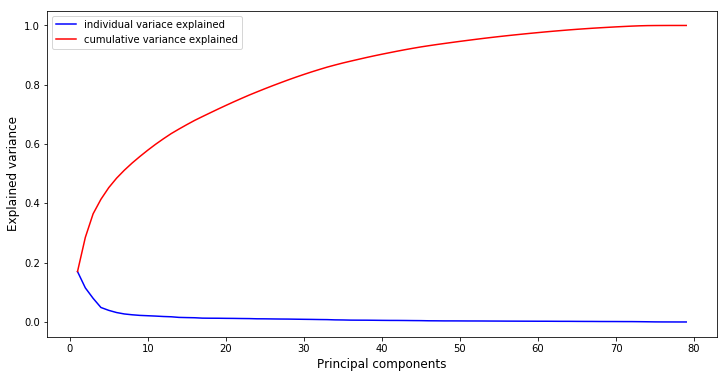

In [97]:
# Investigate the variance accounted for by each principal component.
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, c='b',
        label='individual variace explained')
ax.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), c='r',
        label='cumulative variance explained')
ax.set_xlabel('Principal components', fontsize=12)
ax.set_ylabel('Explained variance', fontsize=12)
plt.legend()
plt.show()

In [98]:
(pca.explained_variance_ratio_.cumsum()<=0.90).sum()

39

In [99]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=39)
pca_data = pca.fit_transform(scaled_below_thres)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

For further analysis, the first 39 pricipal components are being retained since these 39 together explain 90% of variance within the data. The rest 40 pricipal components explain only the remaining 10% of the data. Please note that although the incremental variance explained by the principal components beyond 7-8 is very less, the cumulative explained by these 8 components alone are is less than 30%. Hence, 39 principal components are chosen since we are approximately creating only half as much features as were present in the orignal dataset (79) and at the same time explaining most of the variance (90%).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [99]:
def investigate_pc(component):
    return pd.DataFrame({'weight':pca.components_[component],
                  'feature':scaled_below_thres.columns},
                columns=['feature', 'weight']).sort_values('weight', ascending=False)

In [100]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

investigate_pc(0)

,feature,weight
65,PLZ8_ANTG3,0.200739
48,CAMEO_DEUG_2015,0.197939
66,PLZ8_ANTG4,0.195404
39,HH_EINKOMMEN_SCORE,0.195239
77,CAMEO_INTL_2015_wealth,0.194402
67,PLZ8_BAUMAX,0.192727
71,ORTSGR_KLS9,0.170078
55,EWDICHTE,0.167660
8,FINANZ_HAUSBAUER,0.159846
52,KBA05_ANTG4,0.141003


In [101]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

investigate_pc(1)

,feature,weight
0,ALTERSKATEGORIE_GROB,0.263578
5,FINANZ_VORSORGER,0.235497
25,SEMIO_ERL,0.223604
24,SEMIO_LUST,0.182723
18,RETOURTYP_BK_S,0.161703
9,FINANZTYP,0.117566
40,W_KEIT_KIND_HH,0.115699
33,SHOPPER_TYP,0.103600
28,SEMIO_KRIT,0.103453
8,FINANZ_HAUSBAUER,0.094190


In [102]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

investigate_pc(2)

,feature,weight
23,SEMIO_VERT,0.337335
19,SEMIO_SOZ,0.260198
20,SEMIO_FAM,0.254452
26,SEMIO_KULT,0.242601
3,FINANZ_MINIMALIST,0.149703
9,FINANZTYP,0.116989
18,RETOURTYP_BK_S,0.097857
21,SEMIO_REL,0.083809
5,FINANZ_VORSORGER,0.082744
40,W_KEIT_KIND_HH,0.079436


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


The **first principal component** palces high weights on the following features: 
- Positive:
     - `CAMEO_DEUG_2015` (German CAMEO: Wealth / Life Stage Typology, rough scale)
     - `PLZ8_ANTG3` (Number of 6-10 family houses in the PLZ8 region)
     - `PLZ8_ANTG4` (Number of 10+ family houses in the PLZ8 region) 

- Negative:
    - `LP_STATUS_FEIN` (Social status, fine scale)
    - `LP_STATUS_GROB` (Social status, rough scale)
    - `PLZ8_ANTG1` (Number of 1-2 family houses in the PLZ8 region) 
    
_Interpertation_: 
It appears that the first principal component tries to distinguish poor from others. Specifically, since it places positive weight on the `CAMEO_DEUG_2015` (which has lower values for wealthy people) and negative value for `LP_STATUS_FEIN` (which has higher value for wealthy people), this component gives high positive value for not-so-rich people, and a high negative value for the rich. Also, it makes sense that the weights for these two features are opposite in signs as one gives a high value for wealthy whereas the other gives a low value for them.


The **second principal component** palces high weights on the following features: 
- Positive:
     - `ALTERSKATEGORIE_GROB` (Estimated age)
     - `FINANZ_VORSORGER` (be prepared - financial topology)
     - `SEMIO_ERL` (event-oriented personlity topology) 

- Negative:
    - `SEMIO_REL` (religious affinity personality topology)
    - `PRAEGENDE_JUGENDJAHRE_decade` (Dominating movement of person's youth (created variable))
    - `FINANZ_SPARER` (money-saver financial topology) 
    
_Interpertation_: 

The second principal component tries to distinguish the old from the young. Since `PRAEGENDE_JUGENDJAHRE_decade` (which has a higher value for younger people) has a negative weight and `ALTERSKATEGORIE_GROB` (which has a higher value for older people) has a positive weight, this component gives high positive value to older people and a high negative value for the younger people. Interstingly, since `FINANZ_VORSORGER` (which assigns a higher value for people with very low financial preparedness) and `FINANZ_SPARER` (which assigs a higher value for very low money-savers), it appears that younger generation are inherently low money-savers and older generation are less prepared for financial burdens. Again, the positive and negative weights for the features makes sense since these features, by thier definitions, are negatively oriented. 


The **third principal** component palces high weights on the following features: 
- Positive:
     - `SEMIO_VERT` (dreamful)
     - `SEMIO_SOZ` (socially-minded)
     - `SEMIO_FAM` (family-minded) 

- Negative:
    - `ANREDE_KZ` (Gender)
    - `SEMIO_KAEM` (combative attitude)
    - `SEMIO_DOM` (dominant-minded) 
    
_Interpertation_: 
The third principal component appears to make a distincition between sociable and unfriendly people since high weights are given to dreamful/sociable and family-minded people and high negative weighs are assigned to combative and dominant-minded individuals. By the nature of the definitions, these are negatively oriented with each othere - and the same is being reflected in their weights.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [104]:
# Over a number of different cluster counts...

from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm

scores_ = []
nclusters = []
for k in tqdm(range(1, 15)):
    nclusters.append(k)
    kmeans = KMeans(k)
    kmeans.fit(pca_data)
    scores_.append(kmeans.score(pca_data)/len(pca_data))
    

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

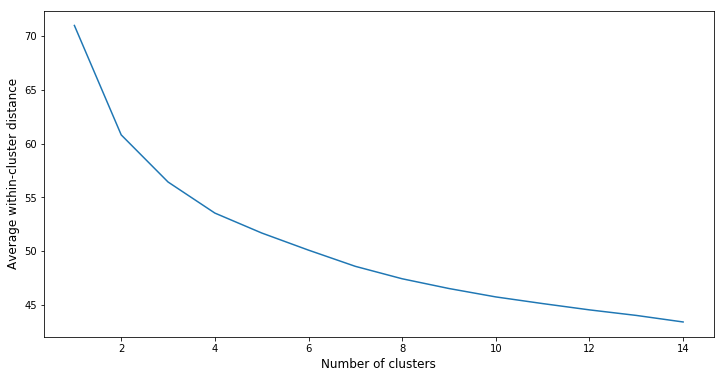

In [112]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(nclusters, [-v for v in scores_])
ax.set_xlabel('Number of clusters', fontsize=12)
ax.set_ylabel('Average within-cluster distance', fontsize=12)
plt.show()

In [114]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=12)
kmeans.fit(pca_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [117]:
population_assignment = kmeans.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I have decided to segment the population into 12 clusters. This is so because from the above plot it is apparent that the rate of decrease in the average within-cluster distance falls drastically beyond 12 clusters. Hence, the benefit in the average within-cluster distance beyond 12 clusters in marginal and too low.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [119]:
!ls


AZDIAS_Feature_Summary.csv	  terms_and_conditions
Data_Dictionary.md		  Udacity_AZDIAS_Subset.csv
Identify_Customer_Segments.ipynb  Udacity_CUSTOMERS_Subset.csv


In [120]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [122]:
customers.shape

(191652, 85)

In [123]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customer = clean_data(customers)

In [124]:
cleaned_customer.shape

(141725, 79)

Check for missing values

In [125]:
cleaned_customer.isnull().sum()

ALTERSKATEGORIE_GROB                233
ANREDE_KZ                             0
CJT_GESAMTTYP                      3124
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
FINANZTYP                             0
GFK_URLAUBERTYP                    3124
GREEN_AVANTGARDE                      0
HEALTH_TYP                         2339
LP_FAMILIE_FEIN                    9398
LP_FAMILIE_GROB                    9398
LP_STATUS_FEIN                     3124
LP_STATUS_GROB                     3124
NATIONALITAET_KZ                   2106
RETOURTYP_BK_S                     3124
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0


Imputing with the same logic used for the entire population.

In [126]:
imputation_df

,feature,impute_value
0,ALTERSKATEGORIE_GROB,3.0
1,ANREDE_KZ,2.0
2,CJT_GESAMTTYP,4.0
3,FINANZ_MINIMALIST,3.0
4,FINANZ_SPARER,1.0
5,FINANZ_VORSORGER,5.0
6,FINANZ_ANLEGER,1.0
7,FINANZ_UNAUFFAELLIGER,1.0
8,FINANZ_HAUSBAUER,5.0
9,FINANZTYP,6.0


In [156]:
imputer_ = {}
for i, j in imputation_df.iterrows():
    imputer_[j.feature] = j.impute_value

In [161]:
cleaned_customer = cleaned_customer.fillna(imputer_)

In [164]:
cleaned_customer.isnull().sum().sum()

0

In [180]:
scaled_customer = scaler.transform(cleaned_customer)

In [181]:
pca_customer = pca.transform(scaled_customer)

In [182]:
pca_customer.shape

(141725, 39)

In [184]:
customer_assignment = kmeans.predict(pca_customer)

In [185]:
customer_assignment

array([9, 7, 6, ..., 9, 5, 6], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [192]:
pop_tmp = pd.Series(population_assignment).value_counts().reset_index()

In [194]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pop_tmp = pd.Series(population_assignment).value_counts().reset_index()
pop_tmp.columns = ['cluster', 'counts']
pop_tmp.sort_values('cluster', inplace=True)

cust_tmp = pd.Series(customer_assignment).value_counts().reset_index()
cust_tmp.columns = ['cluster', 'counts']
cust_tmp.sort_values('cluster', inplace=True)

In [195]:
cust_tmp

,cluster,counts
10,0,1395
5,1,9578
7,2,7163
11,3,1102
3,4,11739
4,5,9895
1,6,24316
2,7,16792
9,8,1975
0,9,47665


# The rows with a large number of missing values are added to cluster number `12` - both for customer and general population datasets.

Adding rows with missing values beyond the set threshold to the new cluster 12

In [204]:
cust_tmp = cust_tmp.append(pd.DataFrame({'cluster': 12, 'counts': customers.shape[0]-cleaned_customer.shape[0]}, index=[12]))

In [205]:
pop_tmp = pop_tmp.append(pd.DataFrame({'cluster': 12, 'counts': azdias.shape[0]-below_thres.shape[0]},
                                     index=[12]))

In [209]:
cust_tmp['pct'] = cust_tmp['counts']*100/cust_tmp['counts'].sum()
pop_tmp['pct'] = pop_tmp['counts']*100/pop_tmp['counts'].sum()

In [210]:
cust_tmp

,cluster,counts,pct
10,0,1395,0.727882
5,1,9578,4.997600
7,2,7163,3.737503
11,3,1102,0.575001
3,4,11739,6.125164
4,5,9895,5.163004
1,6,24316,12.687580
2,7,16792,8.761714
9,8,1975,1.030514
0,9,47665,24.870599


In [211]:
pop_tmp

,cluster,counts,pct
1,0,83430,9.361314
5,1,66172,7.424870
11,2,55106,6.183203
6,3,64278,7.212352
3,4,70811,7.945392
4,5,70406,7.899948
2,6,73331,8.228150
7,7,58531,6.567507
0,8,83930,9.417417
9,9,58339,6.545963


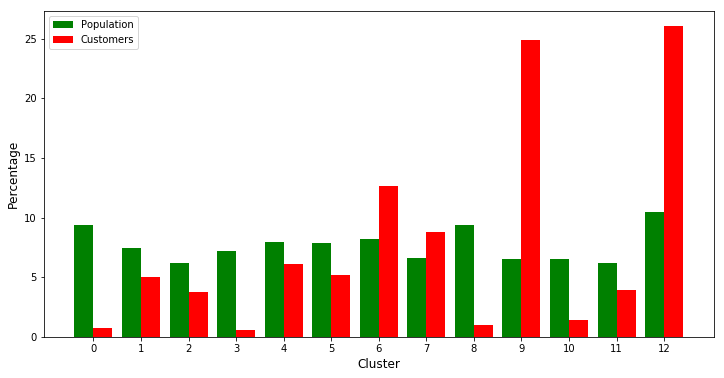

In [224]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(pop_tmp.cluster.values - 0.2, height=pop_tmp.pct.values, width=0.4, align='center', color='g',
      label='Population')
ax.bar(cust_tmp.cluster.values + 0.2, height=cust_tmp.pct.values, width=0.4, align='center', color='r',
      label='Customers')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticks(range(13))
plt.legend()
plt.show()

In [226]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

summary = pd.merge(pop_tmp[['cluster', 'pct']], cust_tmp[['cluster', 'pct']], 
              on='cluster', how='inner', suffixes=['_pop', '_cust'])

In [228]:
summary['diff (pop - cust)'] = summary['pct_pop'] - summary['pct_cust']

In [230]:
summary.sort_values('diff (pop - cust)')

,cluster,pct_pop,pct_cust,diff (pop - cust)
9,9,6.545963,24.870599,-18.324635
12,12,10.452065,26.050863,-15.598798
6,6,8.228150,12.687580,-4.459430
7,7,6.567507,8.761714,-2.194207
4,4,7.945392,6.125164,1.820227
11,11,6.199585,3.891428,2.308156
1,1,7.424870,4.997600,2.427270
2,2,6.183203,3.737503,2.445699
5,5,7.899948,5.163004,2.736945
10,10,6.562233,1.381149,5.181084


Clusters 9 and 12 (12 cluster being rows with too many missing values) are overrepresented in the customer data as compared to the general population data.

In [231]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

summary.sort_values('diff (pop - cust)', ascending=False)

,cluster,pct_pop,pct_cust,diff (pop - cust)
0,0,9.361314,0.727882,8.633433
8,8,9.417417,1.030514,8.386904
3,3,7.212352,0.575001,6.637352
10,10,6.562233,1.381149,5.181084
5,5,7.899948,5.163004,2.736945
2,2,6.183203,3.737503,2.445699
1,1,7.424870,4.997600,2.427270
11,11,6.199585,3.891428,2.308156
4,4,7.945392,6.125164,1.820227
7,7,6.567507,8.761714,-2.194207


Clusters 0, 8, 3 and 10 are underrepresented in the customer data as compared to the general population data.

In [235]:
kmeans.cluster_centers_[9]

array([-4.04846442,  0.27809308,  2.75498397,  2.35899491, -0.41568499,
       -0.46297204, -0.03015404, -0.07500222, -0.05271974,  0.03591646,
       -0.08866956, -0.08653682,  0.29455149,  0.1369751 , -0.28174246,
       -0.27395682,  0.34145867, -0.06615918,  0.09652451, -0.01911009,
        0.03176603, -0.0158237 , -0.06059791, -0.19516974, -0.04129389,
        0.05943522, -0.05390055, -0.18170277,  0.11186585, -0.01888324,
       -0.11836458,  0.03157068, -0.04042554, -0.0127575 ,  0.0202459 ,
       -0.11431337,  0.19619373,  0.16472054,  0.08516686])

In [234]:
kmeans.cluster_centers_[0]

array([ 4.74380537, -1.62647334, -2.48011028,  0.49692288, -0.08478787,
       -0.23530478, -0.12235739, -0.03787228,  0.05816959, -0.15550025,
        0.42615455, -0.07281562,  0.28351032, -0.1056574 ,  0.01010083,
       -0.22344516,  0.07649859,  0.0317402 , -0.07181754, -0.1079521 ,
       -0.05064878, -0.00983448, -0.03237787,  0.04800479, -0.0560264 ,
        0.0122785 , -0.01748227,  0.01921297,  0.11482143,  0.11181933,
        0.10323723, -0.12471465, -0.00494275, -0.10000553,  0.16815904,
        0.02690122,  0.08774388,  0.01711336,  0.0975567 ])

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**The rows with a large number of missing values are added to the cluster number `12` - both for customer and general population datasets (Refer above)**

Cluster 9 is the most overrepresented cluster in the customer data as compared to the population data. Looking at this cluster center, it is apparent that the most intense (positive or negative) value is for the first principal component (-4.048). Since the sign of the value is negative, this cluster represents the opposite of what the first principal component stands for. The first principal component assigns a high positive value for not-so-rich people. Therefore, this cluster represents rich people. In other words, cluster 9 represents rich people. And these set of people are overrepresented in the customer data.

Similarly, cluster 0 is the most underrepresented cluster in the customer data as compare to the population data. Again, looking at this cluster center, the first principal component has the most intense value (positive or negative). Only this time, the value is positive instead of negative. Therefore, applying the same logic, this cluster represents not-so-rich people. Hence, the underrepresented cluster in the customer data are not-so-rich once. This also agrees with the intuitive guess.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.